In [1]:
num_train_timesteps = 50#1000

In [2]:
!rm -rf /content/capstone-camera-traps
! git clone https://github.com/chrishon/capstone-camera-traps.git
%cd capstone-camera-traps

Cloning into 'capstone-camera-traps'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 116 (delta 48), reused 84 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (116/116), 5.40 MiB | 11.02 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/capstone-camera-traps


In [3]:
import video_processing
import torch

In [4]:
from video_processing.prepare_data import extract_frames, prepare_train_data, prepare_train_data_diffusion
from video_processing.post_processing import predict_multiple_samples, multi_sample_frame_analysis, visualize_multiple_comparisons, multi_sample_temporal_analysis, temporal_analysis

In [5]:
device = torch.device('cuda') if  torch.cuda.is_available() else torch.device('cpu')

In [6]:
image_size = (128,128)

In [7]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=64,
    in_channels=3 + 5*3,  # Noisy image (3) + condition (5*3)
    out_channels=3,       # Predict noise
    layers_per_block=2,
    block_out_channels=(128, 256, 512, 512),
    down_block_types=(
        "DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(18, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(1

In [8]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_train_timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear"
)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
from torch.utils.data import DataLoader, TensorDataset
# 1. Extract and prepare data
video_path="/content/drive/MyDrive/capstone-camera-traps/resources/videos/FH102_02 (1).avi"
frames = extract_frames(video_path,size = (128,128),max_frames = 50)

In [11]:
len(frames)

50

In [12]:

X_condition, y_target = prepare_train_data_diffusion(frames, sequence_length=5)

# 2. Create dataloader
X_tensor = torch.tensor(X_condition, dtype=torch.float32)
y_tensor = torch.tensor(y_target, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# 3. Verify shapes
sample_batch = next(iter(train_loader))
condition_batch, target_batch = sample_batch
print(f"Condition shape: {condition_batch.shape}")  # Should be (batch, 15, 64, 64)
print(f"Target shape: {target_batch.shape}")        # Should be (batch, 3, 64, 64)

Condition shape: torch.Size([8, 15, 128, 128])
Target shape: torch.Size([8, 3, 128, 128])


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 8
for epoch in range(num_epochs):
    i = 1
    for batch_condition, batch_target in train_loader:
        print(i)
        i += 1
        batch_condition = batch_condition.to(device)
        batch_target = batch_target.to(device)

        # Sample noise and timesteps
        noise = torch.randn_like(batch_target)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps,
                                 (batch_target.shape[0],), device=device)

        # Add noise to targets
        noisy_images = noise_scheduler.add_noise(batch_target, noise, timesteps)

        # Combine with condition and predict noise
        model_input = torch.cat([noisy_images, batch_condition], dim=1)
        noise_pred = model(model_input, timesteps).sample

        # Compute loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

1


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


2
3
4
5
6
Epoch 1, Loss: 0.9824
1
2
3
4
5
6
Epoch 2, Loss: 0.8604
1
2
3
4
5
6
Epoch 3, Loss: 0.7115
1
2
3
4
5
6
Epoch 4, Loss: 0.6584
1
2
3
4
5
6
Epoch 5, Loss: 0.3516
1
2
3
4
5
6
Epoch 6, Loss: 0.2983
1
2
3
4
5
6
Epoch 7, Loss: 0.3371
1
2
3
4
5
6
Epoch 8, Loss: 0.2318


In [14]:
def predict_next_frame(model, condition, scheduler, device):
    model.eval()
    with torch.no_grad():
        # Initial noise
        sample = torch.randn((1, 3, 128, 128), device=device)
        condition = condition.unsqueeze(0).to(device)

        # Denoising loop
        for t in scheduler.timesteps:
            model_input = torch.cat([sample, condition], dim=1)
            noise_pred = model(model_input, t).sample
            sample = scheduler.step(noise_pred, t, sample).prev_sample

        # Denormalize and format
        predicted_frame = sample.squeeze().cpu().numpy()
        predicted_frame = (predicted_frame + 1) / 2  # [0, 1]
        predicted_frame = np.transpose(predicted_frame, (1, 2, 0))
        return predicted_frame

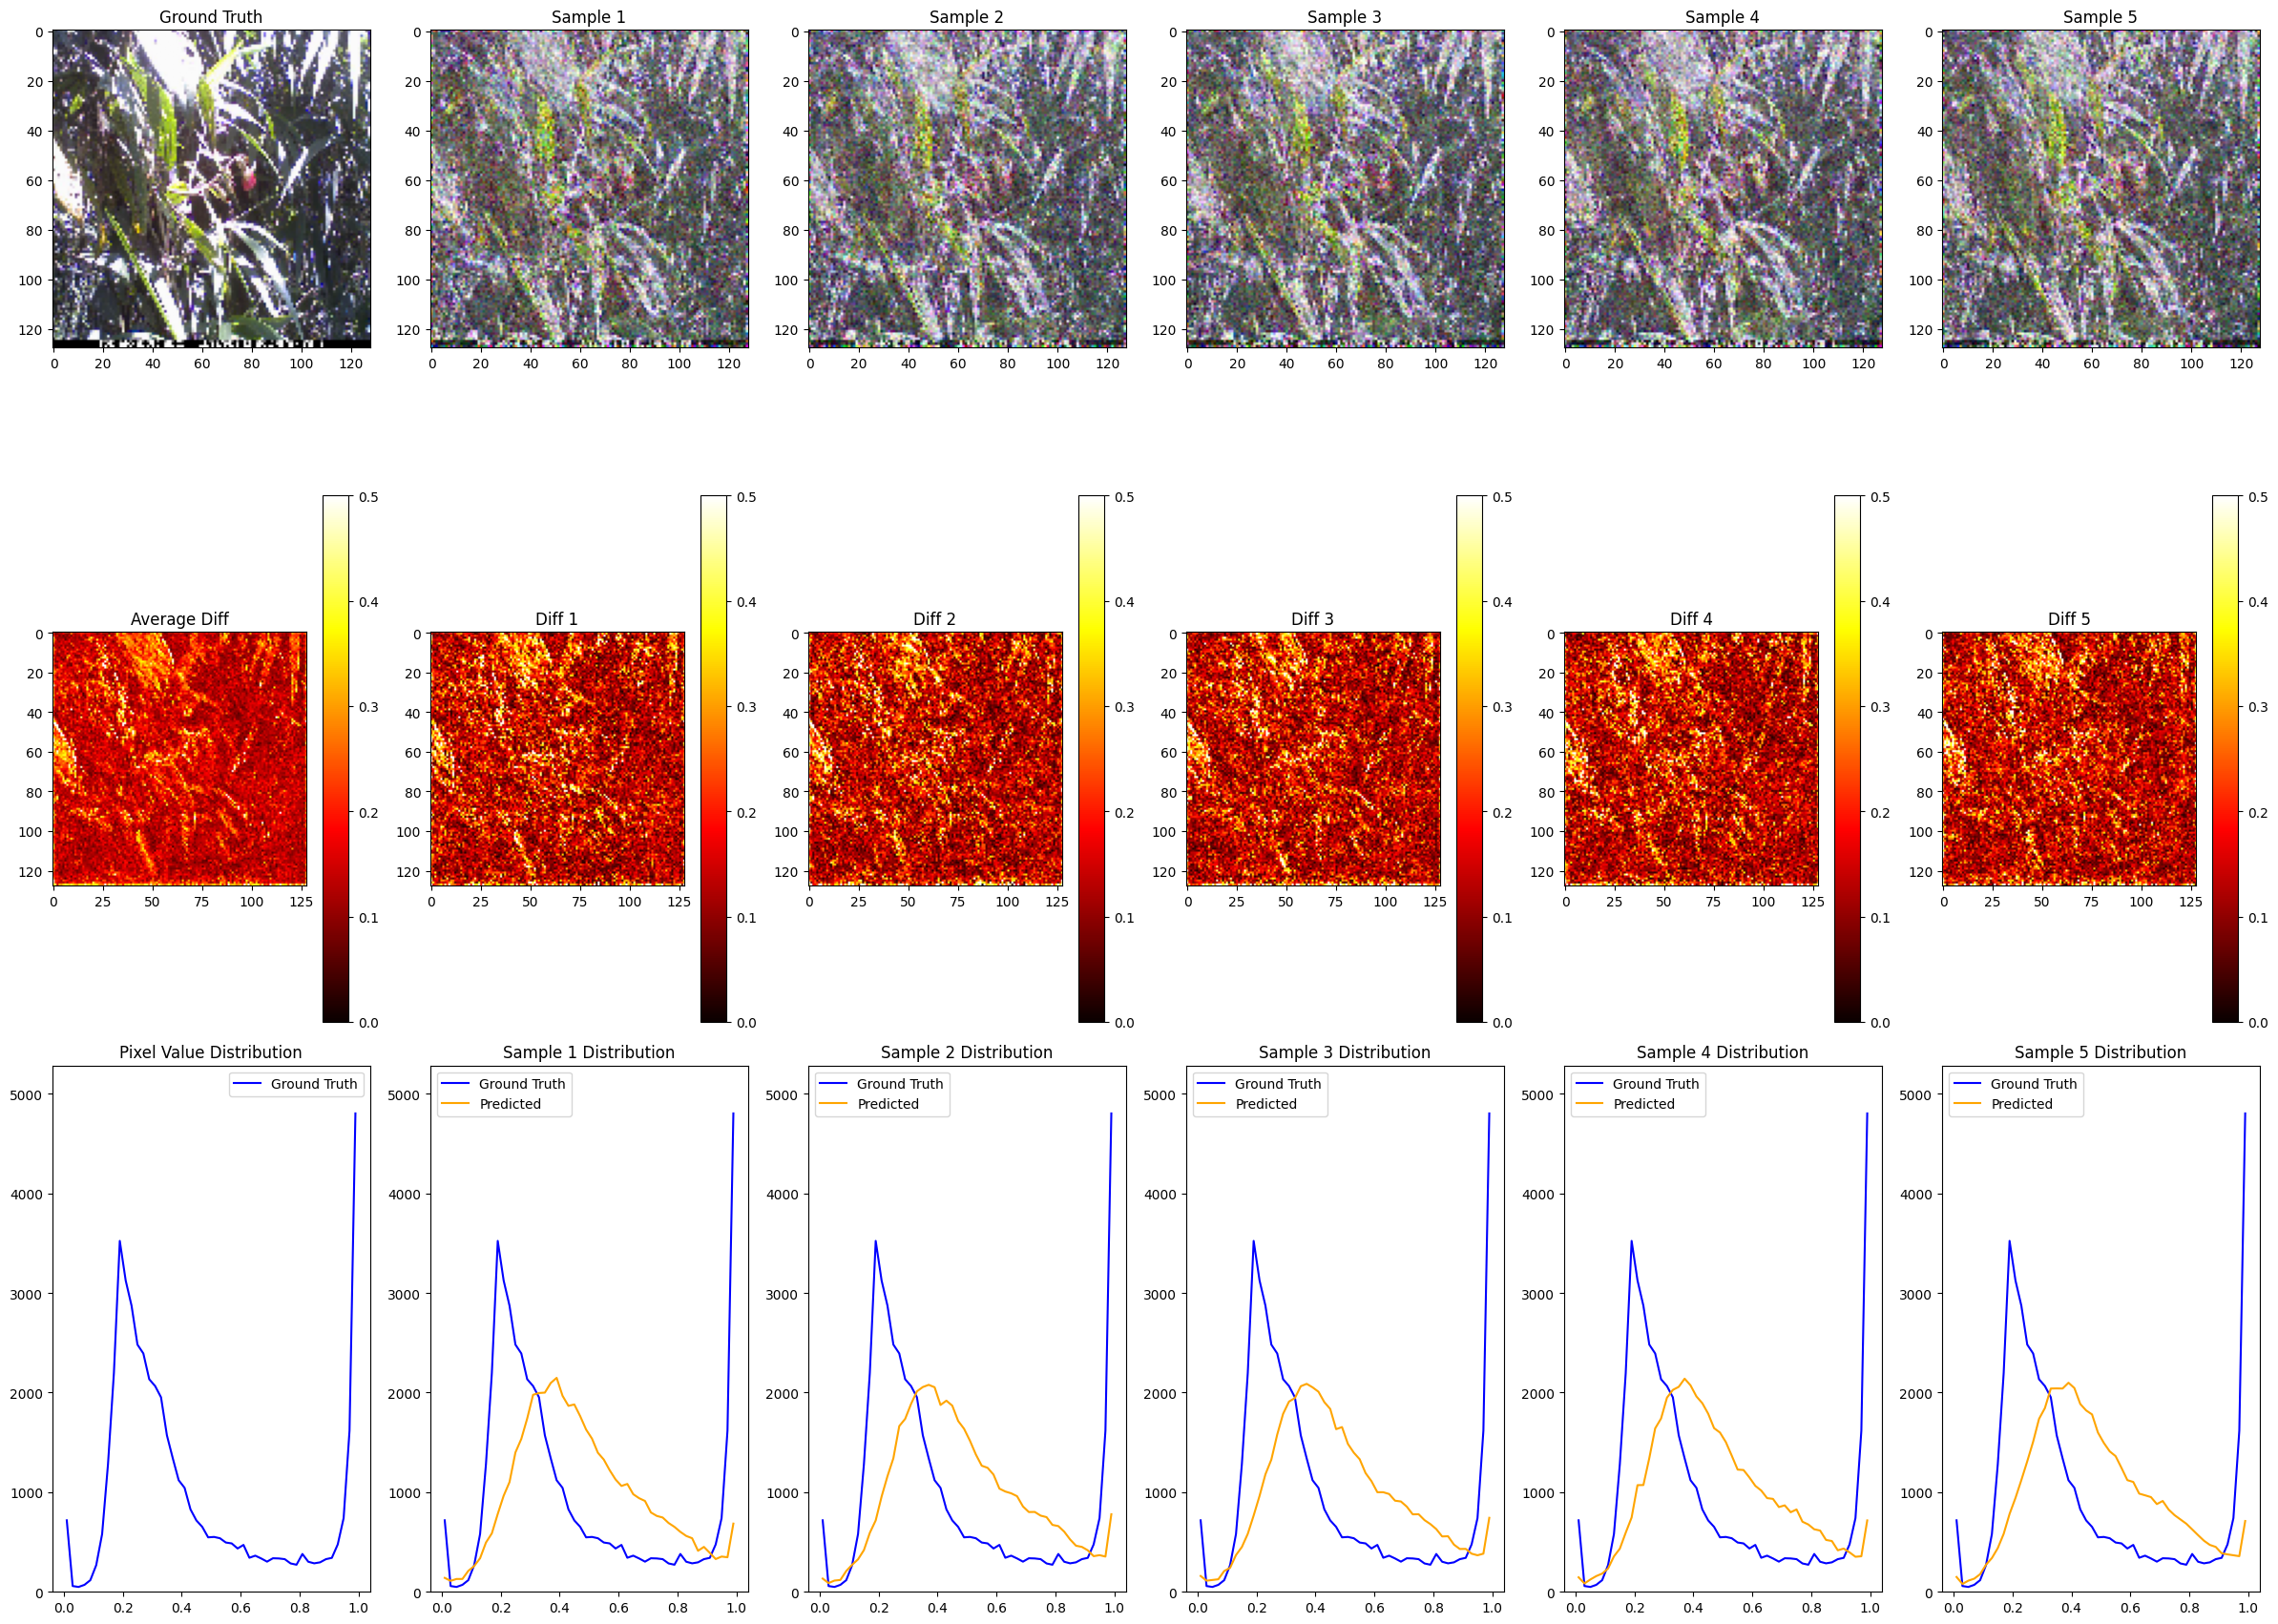

In [15]:
import matplotlib.pyplot as plt
import numpy as np
# Prepare test data
X_condition_test, y_test = X_condition, y_target
# X_condition_test, y_test = prepare_train_data(test_frames)

# Select sample
sample_idx = 3
condition_sample = torch.tensor(X_condition_test[sample_idx], dtype=torch.float32)
actual_frame = (y_test[sample_idx].transpose(1, 2, 0) + 1) / 2  # To HWC and [0,1]

# Generate prediction
predictions = predict_multiple_samples(model, condition_sample, noise_scheduler,
                                      device, num_samples=5,size = image_size)

actual_frame = (y_test[sample_idx].transpose(1, 2, 0) + 1) / 2

# Analyze
analysis = multi_sample_frame_analysis(predictions, actual_frame)

# Plot
visualize_multiple_comparisons(predictions, actual_frame)

In [16]:
def prepare_initial_condition(frames):
    """Convert initial frames to model input format"""
    # Convert to numpy array and normalize
    frames_np = np.array(frames) / 255.0 * 2 - 1  # [-1, 1] range

    # Transpose to (seq_len, C, H, W)
    frames_transposed = np.transpose(frames_np, (0, 3, 1, 2))

    # Combine sequence length and channels
    initial_condition = frames_transposed.reshape(1, -1, frames_np.shape[1], frames_np.shape[2])

    return initial_condition


In [17]:
def generate_sequence(
    model,
    initial_condition,
    scheduler,
    device,
    num_frames=3,
    sequence_length=5
):
    """Generate a sequence of frames autoregressively"""
    # Initial setup
    current_condition = initial_condition.clone().to(device)
    predicted_frames = []
    C, H, W = 3, image_size[0], image_size[1]  # Update if your resolution differs

    for _ in range(num_frames):
        # Predict next frame (returns tensor in [-1, 1])
        next_frame = predict_next_frame_tensor(model, current_condition, scheduler, device)
        predicted_frames.append(next_frame.cpu())

        # Update condition: Remove oldest frame, add new prediction
        current_condition = torch.cat([
            current_condition[:, 3:],  # Remove oldest 3 channels
            next_frame.unsqueeze(0)    # Add new prediction
        ], dim=1)

    # Denormalize and format
    denorm_frames = [
        (frame.squeeze().numpy().transpose(1, 2, 0) * 0.5 + 0.5)  # [-1,1] → [0,1]
        for frame in predicted_frames
    ]
    return denorm_frames

def predict_next_frame_tensor(model, condition, scheduler, device):
    """Diffusion prediction (returns tensor in [-1, 1])"""
    model.eval()
    with torch.no_grad():
        noise = torch.randn((1, 3, image_size[0], image_size[1]), device=device)
        condition = condition.to(device)

        for t in scheduler.timesteps:
            model_input = torch.cat([noise, condition], dim=1)
            noise_pred = model(model_input, t).sample
            noise = scheduler.step(noise_pred, t, noise).prev_sample

        return noise.squeeze(0)  # (3, H, W)

def get_gt_sequence(frames, start_idx, sequence_length=5, num_frames=3):
    """Extract ground truth sequence from original frames"""
    # Get initial sequence and subsequent frames
    initial_frames = frames[start_idx : start_idx + sequence_length]
    gt_sequence = frames[start_idx + sequence_length : start_idx + sequence_length + num_frames]

    # Convert to [0, 1] range
    gt_sequence = [frame.astype(np.float32) / 255.0 for frame in gt_sequence]
    return gt_sequence

# Parameters
sequence_length = 5
num_pred_frames = 20
start_idx = 0  # Starting point in video

# Get initial frames for conditioning
initial_frames = frames[start_idx : start_idx + sequence_length]

# Prepare initial condition tensor
initial_condition_np = prepare_initial_condition(initial_frames)
initial_condition = torch.tensor(initial_condition_np, dtype=torch.float32).to(device)

# Generate predicted sequence
predicted_sequence = generate_sequence(
    model,
    initial_condition,
    noise_scheduler,
    device,
    num_frames=num_pred_frames
)

# Get ground truth sequence
gt_sequence = get_gt_sequence(
    [f.astype(np.uint8) for f in frames],  # Original uint8 frames
    start_idx,
    num_frames=num_pred_frames
)

In [18]:


# Analyze sequences
pred_metrics = temporal_analysis(predicted_sequence)
gt_metrics = temporal_analysis(gt_sequence)

# Compare metrics
def compare_metrics(pred, gt):
    print(f"{'Metric':<25} {'Predicted':<10} {'GT':<10} {'Diff':<10}")
    for key in pred:
        p_val = np.mean(pred[key])
        g_val = np.mean(gt[key])
        print(f"{key:<25} {p_val:.4f}     {g_val:.4f}     {abs(p_val - g_val):.4f}")

compare_metrics(pred_metrics, gt_metrics)

Metric                    Predicted  GT         Diff      
flow_magnitude            0.5565     0.5502     0.0062
intensity_change          0.1271     0.0627     0.0644
temporal_ssim             0.4304     0.7855     0.3551


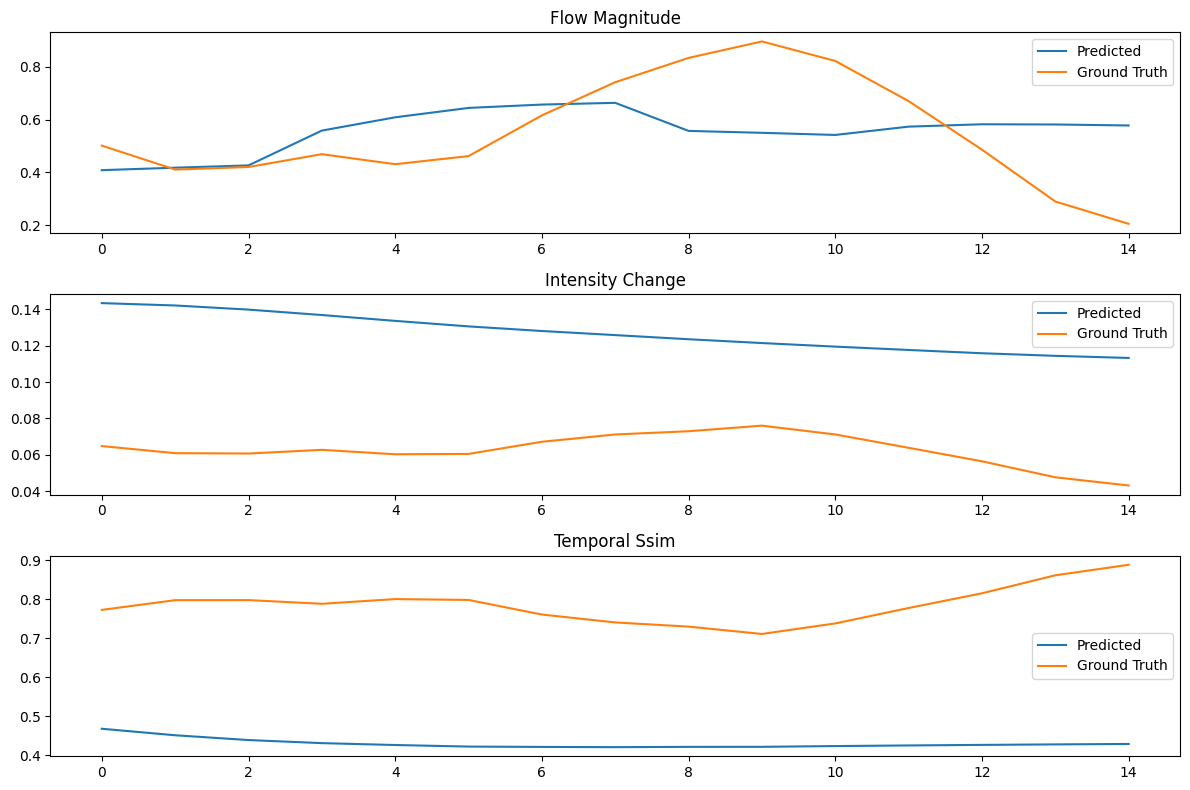

In [19]:
def plot_temporal_comparison(pred_metrics, gt_metrics):
    fig, axs = plt.subplots(3, 1, figsize=(12, 8))
    metrics = ['flow_magnitude', 'intensity_change', 'temporal_ssim']

    for i, metric in enumerate(metrics):
        axs[i].plot(pred_metrics[metric], label='Predicted')
        axs[i].plot(gt_metrics[metric], label='Ground Truth')
        axs[i].set_title(metric.replace('_', ' ').title())
        axs[i].legend()

    plt.tight_layout()
    plt.show()

plot_temporal_comparison(pred_metrics, gt_metrics)